# Install mamba and dependencies

In [ ]:
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=137750683 sha256=b264292652a34fb9dd0ce880a34a4407ba7256a3338388d056769ec29a4581c9
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm


In [ ]:
from mamba_ssm import Mamba
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *
from einops import rearrange

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [ ]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-7-01")
train_start_date = pd.to_datetime("2022-01-01")
out_cols = ['pct_change']
epochs = 25
batch_size = 32
d_model = 128 # number of input features to encoder layer
nhead = 32 # number of heads in multiheadattention
num_layers = 64 # number of encoder layers
dropout = 0.1 # dropout probability

# loading data
data_path = 'drive/MyDrive/data'
interval = '1d'
companies = os.listdir(data_path)
companies = random.sample(companies, 30)
# companies = ['AAPL', 'GOOGL', 'NVDA', ]
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

In [ ]:
def load_data(
    companies: list[str],
    ids: np.array,
    data_path: str,
    interval: str,
    train_start_date: pd.Timestamp,
    test_start_date: pd.Timestamp,
    out_cols: list[str],
    seq_size: int,
):
    """
    Function to load data from csv files in company folders

    Inputs
        companies: list of company tickers for data to be loaded
        ids: array of floats for each company ticker
        data_path: path where comapany folders are located
        interval: frequency of stock price data (1d, 1h, etc)
        train_start_date: first date to include in training data
        test_start_date: first test date to include in testing data
        out_cols: names of columns that the model will predict
        seq_size: number of datapoints in each sequence before prediction

    Outputs
        train_loader: training set dataloader for model
        test_loader: test set dataloader for model
        indims: number of input dimensions for model
        outdims: number of output dimensions for model
        dates: test set prediction dates
        company_stats: dictionary where the keys are the ticker and values are that company's stat dict (see z_norm documentation)
        num_to_ticker: dictionary where the keys are the unique number from ids and values are respective ticker
        ticker_to_num: dictionary where the keys are the company ticker and the values are the unique number for that ticker
        feature_cols_idx: index of output feature columns for use in training (since number of columns in y must be equal to number of columns in x in TensorDataset)
    """

    company_stats = dict()  # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    x_train = []
    x_test = []
    y_train = []
    y_test = []
    dates = []

    for co in tqdm(companies):
        files = os.listdir(os.path.join(data_path, co))
        for f in files:  # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df["date"] = pd.to_datetime(df["date"])
        # remove blank column
        df = df.drop(columns=["Unnamed: 0"])
        # remove data before training start date
        df = df[df["date"] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, ["date", 'pct_change'])
        # add ticker column
        df_normed["ticker"] = ticker_to_num[co]

        cols = list(df_normed.columns)
        cols.append(
            cols.pop(cols.index("date"))
        )  # move date to end of list since this will be the order of columns for output df

        # get index of test start date
        test_start_idx = np.min(np.argmax(df_normed["date"] >= test_start_date))

        # get dates for test data
        pred_dates = df_normed["date"].iloc[test_start_idx + seq_size :].tolist()
        dates.append(pred_dates)

        # drop date column before making sequences
        df_normed = df_normed.drop(columns=["date"])

        # store column indices for extracting output features we want
        feature_cols_idx = [
            list(df_normed.columns).index(feature) for feature in out_cols
        ]

        # convert to 2D numpy array of shape (-1, num_cols)
        data_arr = df_normed.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, data_arr)
        for i in range(len(x)):
            if i < test_start_idx - seq_size:
                x_train.append(x[i])
                y_train.append(y[i])
            else:
                x_test.append(x[i])
                y_test.append(y[i])

        company_stats[co] = stat_dict

    indims = y_train[0].shape[0]
    outdims = len(out_cols)
    dates = [element for nestedlist in dates for element in nestedlist]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
    y_test = np.vstack(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return (
        train_loader,
        test_loader,
        indims,
        outdims,
        dates,
        company_stats,
        num_to_ticker,
        ticker_to_num,
        feature_cols_idx,
    )


(
    train_loader,
    test_loader,
    indims,
    outdims,
    dates,
    company_stats,
    num_to_ticker,
    ticker_to_num,
    feature_cols_idx,
) = load_data(
    companies,
    ids,
    data_path,
    interval,
    train_start_date,
    test_start_date,
    out_cols,
    seq_size,
)

100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x


class MambaModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, seq_size=29, d_state=16, d_conv=4, expand=2, dropout=0.2):
        super(MambaModel, self).__init__()
        self.mamba = Mamba(d_model=input_dim, d_state=d_state, d_conv=d_conv, expand=expand)
        self.d1_nn = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(in_features=seq_size*input_dim, out_features=output_dim)

    def forward(self, x):
        y = self.mamba(x)
        y = rearrange(y, 'B L F -> B (L F)') # flatten sequences
        y = self.d1_nn(y)
        y = self.fc1(y)
        return y

# model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
model = MambaModel(input_dim=indims, output_dim=outdims, seq_size=seq_size, d_state=32, d_conv=4, expand=4, dropout=0.1).to(device)

In [ ]:
# Train the model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        y_batch[y_batch <= 0] = 0
        y_batch[y_batch > 0] = 1
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            y_batch[y_batch <= 0] = 0
            y_batch[y_batch > 0] = 1
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    #### uncomment below to add early stopping ####

    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  4%|▍         | 1/25 [00:03<01:18,  3.28s/it]

Epoch 1/25, Train Loss: 0.6922, Validation Loss: 0.6941


  8%|▊         | 2/25 [00:05<01:07,  2.92s/it]

Epoch 2/25, Train Loss: 0.6872, Validation Loss: 0.6978


 12%|█▏        | 3/25 [00:08<01:03,  2.90s/it]

Epoch 3/25, Train Loss: 0.6802, Validation Loss: 0.7117


 16%|█▌        | 4/25 [00:11<00:58,  2.77s/it]

Epoch 4/25, Train Loss: 0.6714, Validation Loss: 0.7176


 20%|██        | 5/25 [00:13<00:52,  2.63s/it]

Epoch 5/25, Train Loss: 0.6630, Validation Loss: 0.7167


 24%|██▍       | 6/25 [00:16<00:48,  2.54s/it]

Epoch 6/25, Train Loss: 0.6544, Validation Loss: 0.7324


 28%|██▊       | 7/25 [00:18<00:46,  2.57s/it]

Epoch 7/25, Train Loss: 0.6461, Validation Loss: 0.7522


 32%|███▏      | 8/25 [00:21<00:45,  2.69s/it]

Epoch 8/25, Train Loss: 0.6309, Validation Loss: 0.7577


 36%|███▌      | 9/25 [00:24<00:41,  2.58s/it]

Epoch 9/25, Train Loss: 0.6251, Validation Loss: 0.7672


 40%|████      | 10/25 [00:26<00:37,  2.51s/it]

Epoch 10/25, Train Loss: 0.6196, Validation Loss: 0.7701


 44%|████▍     | 11/25 [00:28<00:34,  2.47s/it]

Epoch 11/25, Train Loss: 0.6139, Validation Loss: 0.7748


 48%|████▊     | 12/25 [00:31<00:31,  2.43s/it]

Epoch 12/25, Train Loss: 0.6098, Validation Loss: 0.7859


 52%|█████▏    | 13/25 [00:34<00:31,  2.62s/it]

Epoch 13/25, Train Loss: 0.6030, Validation Loss: 0.7972


 56%|█████▌    | 14/25 [00:36<00:28,  2.57s/it]

Epoch 14/25, Train Loss: 0.5971, Validation Loss: 0.8090


 60%|██████    | 15/25 [00:38<00:24,  2.49s/it]

Epoch 15/25, Train Loss: 0.5949, Validation Loss: 0.8144


 64%|██████▍   | 16/25 [00:41<00:21,  2.44s/it]

Epoch 16/25, Train Loss: 0.5908, Validation Loss: 0.8205


 68%|██████▊   | 17/25 [00:43<00:19,  2.40s/it]

Epoch 17/25, Train Loss: 0.5869, Validation Loss: 0.8254


 72%|███████▏  | 18/25 [00:46<00:17,  2.55s/it]

Epoch 18/25, Train Loss: 0.5844, Validation Loss: 0.8314


 76%|███████▌  | 19/25 [00:49<00:15,  2.57s/it]

Epoch 19/25, Train Loss: 0.5833, Validation Loss: 0.8318


 80%|████████  | 20/25 [00:51<00:12,  2.50s/it]

Epoch 20/25, Train Loss: 0.5758, Validation Loss: 0.8436


 84%|████████▍ | 21/25 [00:53<00:09,  2.45s/it]

Epoch 21/25, Train Loss: 0.5777, Validation Loss: 0.8429


 88%|████████▊ | 22/25 [00:56<00:07,  2.56s/it]

Epoch 22/25, Train Loss: 0.5738, Validation Loss: 0.8589


 92%|█████████▏| 23/25 [00:59<00:05,  2.73s/it]

Epoch 23/25, Train Loss: 0.5724, Validation Loss: 0.8531


 96%|█████████▌| 24/25 [01:02<00:02,  2.70s/it]

Epoch 24/25, Train Loss: 0.5715, Validation Loss: 0.8673


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]

Epoch 25/25, Train Loss: 0.5736, Validation Loss: 0.8615


In [ ]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(torch.sigmoid(outputs), batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
#     df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date', 'pct_change'])

df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
df_merged = pd.merge(df_pred, df_gt, 'inner')

110it [00:00, 141.18it/s]


In [ ]:
# df_merged['new_pct_change_pred'] = df_merged['pct_change_pred'].pct_change()
# df_merged = df_merged.dropna()
df_merged.head()

,pct_change_pred,ticker,date,pct_change_gt
0,0.792495,CAG,2023-08-15,-0.019741
1,0.719500,CAG,2023-08-16,-0.008584
2,0.720800,CAG,2023-08-17,-0.002664
3,0.678392,CAG,2023-08-18,0.008013
4,0.815681,CAG,2023-08-21,-0.013249


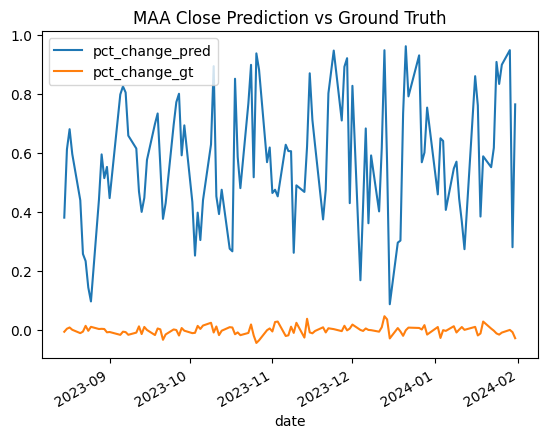

In [ ]:
co = companies[1]
df_merged[df_merged['ticker'] == co].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"{co} Close Prediction vs Ground Truth")
plt.show()

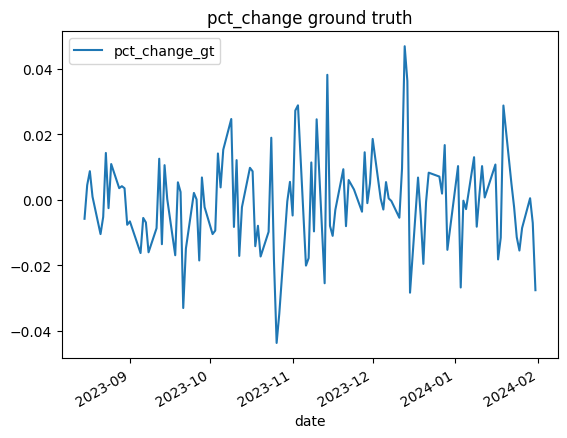

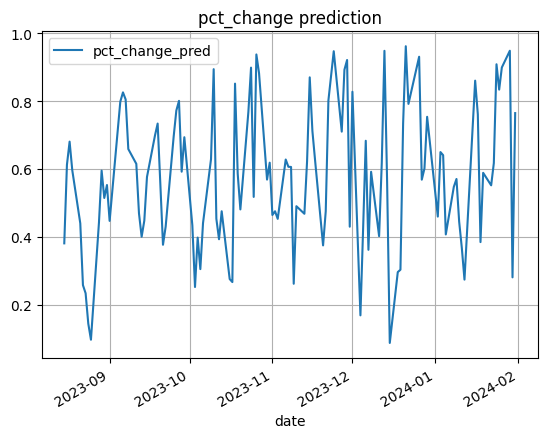

In [ ]:
df_merged[df_merged['ticker'] == co].plot(x='date', y='pct_change_gt')
plt.title("pct_change ground truth")
plt.show()
df_merged[df_merged['ticker'] == co].plot(x='date', y='pct_change_pred')
plt.grid()
plt.title("pct_change prediction")
plt.show()

In [ ]:
accuracy_metrics = dict()
for i in range(len(companies)):
    accuracy_metrics[companies[i]] = dict()
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    da = directional_accuracy_pct_change(gt_rows, pred_rows)
    pct_increasing = (gt_rows >= 0).sum()/len(gt_rows)
    accuracy_metrics[companies[i]]["directional accuracy"] = da
    accuracy_metrics[companies[i]]["pct increasing"] = pct_increasing
    accuracy_metrics[companies[i]]["pred vs gt DA difference"] = da - pct_increasing

    print(f"{companies[i]} DA improvement over buy and hold: {accuracy_metrics[companies[i]]['pred vs gt DA difference']:.4f}")


CAG DA improvement over buy and hold: -0.0171
MAA DA improvement over buy and hold: 0.0000
BX DA improvement over buy and hold: 0.0000
CVS DA improvement over buy and hold: -0.0171
MET DA improvement over buy and hold: -0.0085
TSN DA improvement over buy and hold: 0.0000
AMT DA improvement over buy and hold: 0.0000
FICO DA improvement over buy and hold: 0.0000
LIN DA improvement over buy and hold: 0.0000
GOOGL DA improvement over buy and hold: 0.0000
FRT DA improvement over buy and hold: -0.0085
OTIS DA improvement over buy and hold: 0.0000
ESS DA improvement over buy and hold: -0.0085
AWK DA improvement over buy and hold: -0.0085
GILD DA improvement over buy and hold: 0.0000
DD DA improvement over buy and hold: 0.0000
GRMN DA improvement over buy and hold: -0.0256
AME DA improvement over buy and hold: -0.0085
DLTR DA improvement over buy and hold: 0.0000
WY DA improvement over buy and hold: -0.0085
KIM DA improvement over buy and hold: -0.0085
ADBE DA improvement over buy and hold: 0.

In [ ]:
accuracy_metrics[companies[0]]

{'directional accuracy': 0.41025641025641024,
 'pct increasing': 0.42735042735042733,
 'pred vs gt DA difference': -0.01709401709401709}

In [ ]:
companies[0]

'CAG'